# Aerobicity phenotype: data analysis, processing, and visualization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             f1_score, mutual_info_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

from xgboost import XGBClassifier
import shap

In [3]:
target_column = 'oxytolerance'
threads = 64

## 1. Read the dataset

In [4]:
### FUNCTION

def read_aerob_data(
    X_data_path='../data/all_gene_annotations.added_incompleteness_and_contamination.tsv', y_data_path = '../data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv',
    bac_phylogeny_data_path='../data/bac120_metadata_r202.tsv', arch_phylogeny_data_path='../data/ar122_metadata_r202.tsv',
    target_column = 'oxytolerance'):
    """
    Read aerobicity data:
    :param str X_data_path: Path to the feature table
    :param str y: Path to the labels table
    :param str bac_phylogeny_data_path: Path to the phylogenetic annotation table for bacteria
    :param arch_phylogeny_data_path: Path to the phylogenetic annotation table for archaeae
    :param target_column: Column name of the target
    :return: pandas.DataFrame
    """
    
    # Read GTDB phylogenetic annotation table
    gtdb = pl.concat([
        pl.read_csv(bac_phylogeny_data_path, separator='\t'),
        pl.read_csv(arch_phylogeny_data_path, separator='\t')
    ])
    gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
    print("Read in {} GTDB representatives".format(len(gtdb)))
    
    gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(0).alias("domain"))
    gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
    gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
    gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
    gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
    gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))
    
    # Read feature table
    X_data = pl.read_csv(X_data_path, separator='\t')
    
    # Read y
    y_data = pl.read_csv(y_data_path, separator='\t')
    y_data = y_data.unique() # There are some duplicates in the cyanos, so dedup

    # Add phylogenetic annotation (join based on accession)
    full_data = X_data.join(gtdb.select(['accession','domain', 'phylum','class','order','family','genus']), on="accession", how="left")
    full_data = full_data.join(y_data, on="accession", how="inner") # Inner join because test accessions are in y1 but not in full_data
    
    # Use data w/o noise: w/o FP FN
    print(f'\nData with noise: {len(full_data)}')
    full_data = full_data.filter(pl.col("false_negative_rate") == 0)
    full_data = full_data.filter(pl.col("false_positive_rate") == 0)
    print(f'Data without noise: {len(full_data)}')

    # Map y labels
    y = y_data
    
    classes_map = {
        'anaerobe': 0,
        'aerobe': 1,
    }      
    
    y = full_data.with_columns(
        pl.col(target_column)
        .replace_strict(classes_map, default='unknown')
        .alias(target_column)
    )
    y = y.with_columns(
        pl.col(target_column).cast(pl.Int32)  # Change to Int32
    )    
    print("\nCounts of y:", y.group_by(target_column).agg(pl.len()))
    y = y.to_pandas().iloc[:, -1]

    # Make X dataframe
    X = full_data.select(pl.exclude(['accession',target_column,'domain','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()
    # Blacklist these as they aren't in the current ancestral file, not sure why
    X = X.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'], axis=1)

    return X, y, full_data

In [5]:
X, y, full_data = read_aerob_data()

Read in 47894 GTDB representatives

Data with noise: 113796
Data without noise: 3161

Counts of y: shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 1            ┆ 2106 │
│ 0            ┆ 1055 │
└──────────────┴──────┘


## 2. PCA and tSNE projections

*All features*

In [6]:
import os
import random 
import torch
import logging 
import pandas as pd
import numpy as np
import polars as pl
import argparse
from matplotlib import cm
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import accuracy_score

from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MaxAbsScaler

from sklearn.model_selection import cross_val_predict, KFold
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error,r2_score

In [7]:
from utils.utils import pca_run_and_plot, tsne_plot

ImportError: cannot import name 'pca_run_and_plot' from 'utils.utils' (/Users/olgabagrova/olgab/gene-context/jupyter_notebooks/utils/utils.py)

In [7]:
#ANZHELIKA's CODE

def pca_run_and_plot(X_train_val, n_compon, y_train_val = None, category_names = None,  colors = None):
   scaler = MaxAbsScaler()

   # Fit and transform the data
   X_train_val = scaler.fit_transform(X_train_val)

   # Run PCA on the X-data
   pca = PCA(n_components=n_compon)
   X_train_pca = pca.fit_transform(X_train_val)
   print(f"Data after PCA reduction: {X_train_pca.shape}")

   # Find the explained variance
   explained_variance_ratio = pca.explained_variance_ratio_

   print("Explained variance ratio:", explained_variance_ratio)
   print("Total explained variance:", sum(explained_variance_ratio))

   listed_cmap = None

  # plt.figure(figsize=(4, 4))
   if y_train_val is not None:
       #Ensure 'y_train_val' has unique, valid labels
       unique_ids = np.unique(y_train_val)

       # Check if 'colors' is already a ListedColormap or needs to be generated
       if isinstance(colors, ListedColormap):
           listed_cmap = colors  # Use the passed ListedColormap directly
       else:
           # Generate colors based on the unique labels in y_train_val
           
           listed_cmap = ListedColormap(cm.nipy_spectral(np.linspace(0, 1, len(unique_ids))))
       scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_val, alpha=0.6, s = 10, label = category_names, cmap=listed_cmap)

       if category_names is not None:
           categ_name_dict = defaultdict(int)
           for i in range(len(y_train_val)):
               categ_id = y_train_val[i]
               #if categ_id not in categ_name_dict.keys():
               categ_id = int(categ_id)
               categ_name_dict[categ_id] = category_names[i]
           labels = [categ_name_dict[unique_id] for unique_id in unique_ids]       

           # Create legend handles and labels based on unique labels
           handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=listed_cmap(i / len(unique_ids)), markersize=10) for i in range(len(unique_ids))]
       

           plt.legend(handles=handles, labels=labels ,loc='upper center', title="Categories", ncol=5) #, bbox_to_anchor=(1.05, 1)
       else:
           plt.colorbar()    
   else:
       scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.6, s = 10)
          
   plt.xlabel(f"PC 1; var = {round(explained_variance_ratio[0],2)}")
   plt.ylabel(f"PC 2; var = {round(explained_variance_ratio[1],2)}")
   plt.title("PCA space")
   plt.grid(True, zorder=1)
   #plt.show()

   return listed_cmap

In [8]:
#ANZHELIKA's CODE

def tsne_plot(X_train, perplexity, learning_rate, random_seed, y_train = None, colors = None):
    scaler = MaxAbsScaler()

    # Fit and transform the data
    X_train_scal = scaler.fit_transform(X_train)


    # Initialize and apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, max_iter=3000, init='pca', random_state=random_seed) 

    if colors is None:
        listed_cmap = ListedColormap(cm.nipy_spectral(np.linspace(0, 1, len(np.unique(y_train)))))
        #colors = ListedColormap(["tab:green", "tab:purple"])
    else:
        listed_cmap = colors    


    X_tsne = tsne.fit_transform(X_train_scal) 

    print(f"Shape of the projected data = {X_tsne.shape}")

    # Visualize the t-SNE output
    if y_train is not None:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, alpha=0.5, s = 10, cmap=listed_cmap)
        if colors is None:
            plt.colorbar()    
    else:
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s = 10)
    plt.xlabel("tSNE1")
    plt.ylabel("tSNE2")
    plt.title("tSNE space")    
    plt.grid(True, zorder=1) 

**Colored by oxytolerance**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11368673 0.06241213 0.05325955 0.0497164  0.03808874 0.02858283
 0.02380564 0.02022968 0.01859523 0.01501915 0.01196015 0.00999742
 0.00853719 0.00788757 0.00746913 0.00696847 0.00635395 0.00614533
 0.00590932 0.00525419]
Total explained variance: 0.49987878210309217
Shape of the projected data = (3161, 2)


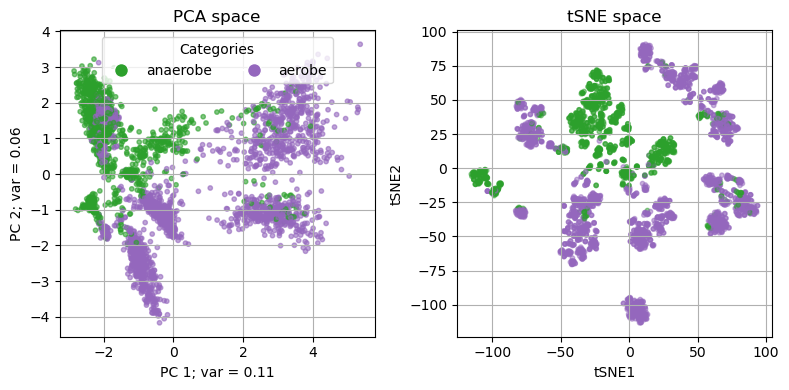

In [9]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X, n_compon, y, category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, y, colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by domain (bacteria vs archaea)**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11368673 0.06241213 0.05325955 0.0497164  0.03808874 0.02858283
 0.02380564 0.02022968 0.01859523 0.01501915 0.01196015 0.00999742
 0.00853719 0.00788757 0.00746911 0.00696861 0.00635376 0.00614517
 0.00591011 0.00526378]
Total explained variance: 0.49988894671209044
Shape of the projected data = (3161, 2)


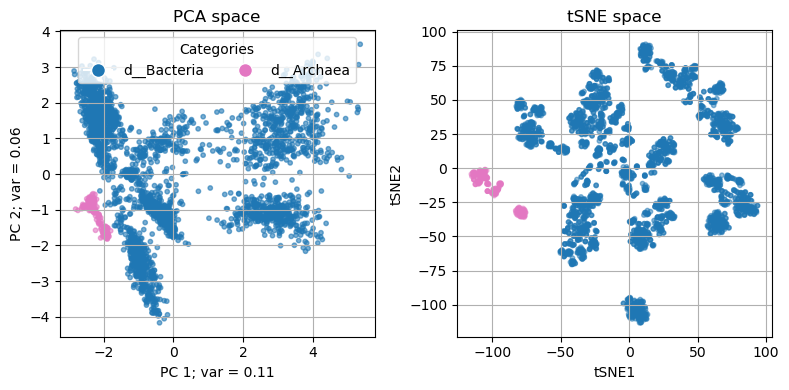

In [10]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = ListedColormap(["tab:blue", "tab:pink"])
category_names = full_data['domain']
pca_run_and_plot(X, n_compon, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']],
                 category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, [0 if a == 'd__Bacteria' else 1 for a in full_data['domain']], colors);


# Display the plots
plt.tight_layout()  
plt.show()

**Colored by Phylum**

Data after PCA reduction: (3161, 20)
Explained variance ratio: [0.11368673 0.06241213 0.05325955 0.0497164  0.03808874 0.02858283
 0.02380564 0.02022968 0.01859523 0.01501915 0.01196015 0.00999742
 0.00853719 0.00788755 0.00746912 0.00696813 0.00635405 0.00614512
 0.00590998 0.00526356]
Total explained variance: 0.49988834715164276
Shape of the projected data = (3161, 2)


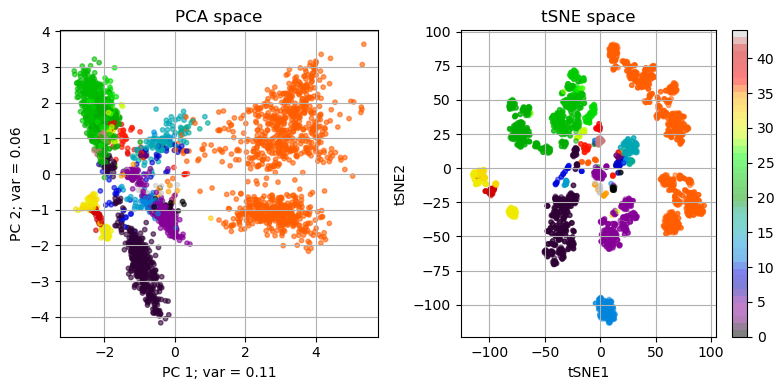

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colors = None
category_names = full_data['phylum']
pca_run_and_plot(X, n_compon, 
                 label_encoder.fit_transform(full_data['phylum']),
                 category_names, colors);
plt.legend().remove()
# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X, 30, 100, 42, 
          label_encoder.fit_transform(full_data['phylum']), 
          colors);


# Display the plots
plt.legend().remove()
plt.tight_layout()  
plt.show()

## 3. XGBoost training and feature selection

**By order**

In [12]:
col_name_to_split = 'order'

groups = full_data[col_name_to_split]
data = pd.DataFrame(X)
data['target'] = y
data['group'] = groups
unique_group = data['group'].unique()

train_groups, test_groups = train_test_split(unique_group, test_size=0.2, random_state=42)
print(f'Train groups: {len(train_groups)}\tTest groups: {len(test_groups)}')

train_mask = data['group'].isin(train_groups)
test_mask = data['group'].isin(test_groups)

X_train = data[train_mask].drop(columns=['target', 'group']).values
y_train = data[train_mask]['target'].values
X_test = data[test_mask].drop(columns=['target', 'group']).values
y_test = data[test_mask]['target'].values

print(f'Train/test split is {(len(y_train)/(len(y_train) + len(y_test)) * 100):.0f}%/{(len(y_test)/(len(y_train) + len(y_test)) * 100):.0f}%')
print(f'Train: {X_train.shape[0]}\tTest: {X_test.shape[0]}')

print(f'\nTrain 0/1: {np.sum(y_train == 0)}/{np.sum(y_train == 1)} \tTest 0/1: {np.sum(y_test == 0)}/{np.sum(y_test == 1)}')

Train groups: 199	Test groups: 50
Train/test split is 81%/19%
Train: 2548	Test: 613

Train 0/1: 804/1744 	Test 0/1: 251/362


In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train =  torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [14]:
#ANZHELIKA's CODE

import numpy as np
import matplotlib.pyplot as plt

import shap
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

def xgboost_train_accur(X_train, y_train, X_test, y_test, device):
    """
    Trains XGBoost for the specified X/y train and test data.
    Returns dictionaries with training accuracy measures calculated for cross-validation and test.
    """
    # Initialize training pipelina
    pipe = make_pipeline(XGBClassifier(n_jobs=THREADS if device == "cpu" else None, tree_method="gpu_hist" if device == "cpu" else "hist"))

    # Run cross-validation and collect the accuracy metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }   
    cv_results = cross_validate(pipe, X_train.cpu(), y_train.cpu(), cv=5, scoring=scoring, return_train_score=False)
    cv_accuracy_scores = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'roc_auc': np.mean(cv_results['test_roc_auc']),
    }

    # Fit on full training set
    pipe.fit(X_train.cpu(), y_train.cpu())

    # Test set predictions
    y_pred = pipe.predict(X_test.cpu())
    y_prob = pipe.predict_proba(X_test.cpu())[:, 1] if len(np.unique(y_train.cpu())) == 2 else None  # binary case

    # Collect final metrics on test set
    test_accuracy_scores = {
        'accuracy': accuracy_score(y_test.cpu(), y_pred),
        'precision': precision_score(y_test.cpu(), y_pred, zero_division=0),
        'recall': recall_score(y_test.cpu(), y_pred, zero_division=0),
        'f1': f1_score(y_test.cpu(), y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test.cpu(), y_prob)
    }
    return cv_accuracy_scores, test_accuracy_scores

In [15]:
cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train, y_train, X_test, y_test, DEVICE)
print(f"XGBoost baseline test accuracy (all features) = {test_accuracy_scores}")
print(f"XGBoost cv_accuracy (all features) = {test_accuracy_scores}")

XGBoost baseline test accuracy (all features) = {'accuracy': 0.9771615008156607, 'precision': np.float64(0.978021978021978), 'recall': np.float64(0.9834254143646409), 'f1': np.float64(0.9807162534435262), 'roc_auc': np.float64(0.9912834848451497)}
XGBoost cv_accuracy (all features) = {'accuracy': 0.9771615008156607, 'precision': np.float64(0.978021978021978), 'recall': np.float64(0.9834254143646409), 'f1': np.float64(0.9807162534435262), 'roc_auc': np.float64(0.9912834848451497)}


### 3.1 Feature selection with Mutual Information

In [16]:
from feature_selection.feature_selection_utils import mutual_info_features


ModuleNotFoundError: No module named 'feature_selection'

In [17]:
#ANZHELIKA's CODE
#?? ASK MI CALCULATIONS BASED ON TRAIN - Should we add others? - think no

def mutual_info_features(X_train, y_train, X_train_column_names, contin_flag = False):
    if contin_flag == False:
        mutual_info = mutual_info_classif(X_train, y_train)
    else:
        mutual_info = mutual_info_regression(X_train, y_train)
    
    sorted_indices = np.argsort(mutual_info)[::-1] 
    sorted_mi = [mutual_info[i] for i in sorted_indices]
    sorted_names = [X_train_column_names[i] for i in sorted_indices]

    return sorted_indices, sorted_mi, sorted_names

In [19]:
X_column_names = X.columns

sorted_cog_idx_by_mi, sorted_mi, sorted_names = mutual_info_features(X_train.cpu(), y_train.cpu(), X_column_names)


In [20]:
sorted_cog_idx_by_mi

array([  81,  964,   18, ..., 2055, 1572,  643])

In [21]:
sorted_mi

[np.float64(0.3583805014778245),
 np.float64(0.34242682408868164),
 np.float64(0.3176374882420243),
 np.float64(0.30864057095650144),
 np.float64(0.304112562432199),
 np.float64(0.2685181254877944),
 np.float64(0.26717214596633454),
 np.float64(0.26383547165986343),
 np.float64(0.25982960683299394),
 np.float64(0.2490617763968479),
 np.float64(0.2449402884249876),
 np.float64(0.23982630776228375),
 np.float64(0.22784494246550935),
 np.float64(0.2257257050805177),
 np.float64(0.22537049876779114),
 np.float64(0.22136189872285028),
 np.float64(0.2197389624780044),
 np.float64(0.21294028336393223),
 np.float64(0.21051089250455446),
 np.float64(0.208969209624148),
 np.float64(0.20252779514760144),
 np.float64(0.20245306439123834),
 np.float64(0.20162847638592596),
 np.float64(0.19899587452766654),
 np.float64(0.1979818850253281),
 np.float64(0.19297623348428083),
 np.float64(0.18866134089220998),
 np.float64(0.1883288129723717),
 np.float64(0.18647081890642325),
 np.float64(0.1807097001042

In [22]:
sorted_names

['COG0109',
 'COG1592',
 'COG0026',
 'COG1612',
 'COG0567',
 'COG0065',
 'COG0508',
 'COG0843',
 'COG0276',
 'COG0365',
 'COG1328',
 'COG1764',
 'COG0167',
 'COG0320',
 'COG1014',
 'COG0543',
 'COG0225',
 'COG0114',
 'COG1838',
 'COG1951',
 'COG0045',
 'COG4624',
 'COG0369',
 'COG1054',
 'COG0074',
 'COG0370',
 'COG0229',
 'COG4231',
 'COG1741',
 'COG0405',
 'COG3185',
 'COG2848',
 'COG2768',
 'COG1342',
 'COG0259',
 'COG4866',
 'COG0788',
 'COG1313',
 'COG3483',
 'COG3830',
 'COG0321',
 'COG1237',
 'COG1249',
 'COG1149',
 'COG0805',
 'COG1146',
 'COG0783',
 'COG2509',
 'COG2225',
 'COG0404',
 'COG0826',
 'COG1578',
 'COG1012',
 'COG0408',
 'COG3508',
 'COG0400',
 'COG2377',
 'COG0415',
 'COG2086',
 'COG0354',
 'COG0221',
 'COG2350',
 'COG2897',
 'COG3844',
 'COG0260',
 'COG3540',
 'COG0431',
 'COG2352',
 'COG1252',
 'COG2191',
 'COG1230',
 'COG1636',
 'COG1845',
 'COG2761',
 'COG1678',
 'COG3324',
 'COG1062',
 'COG0288',
 'COG0618',
 'COG1946',
 'COG2166',
 'COG3346',
 'COG1269',
 'CO

In [27]:
X_train_np = np.array(X_train.cpu())
X_train_transposed = X_train_np.T

In [28]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_mi[:N]
top_N_mi = sorted_mi[:N]
top_N_names_by_mi = sorted_names[:N]
top_feat_mi_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]]

print(f"Top {N} COGs:", top_N_names_by_mi)

Top 10 COGs: ['COG0109', 'COG1592', 'COG0026', 'COG1612', 'COG0567', 'COG0065', 'COG0508', 'COG0843', 'COG0276', 'COG0365']


Data after PCA reduction: (2548, 5)
Explained variance ratio: [0.58168998 0.09606075 0.06774218 0.05833676 0.04500238]
Total explained variance: 0.8488320474163463
Shape of the projected data = (2548, 2)


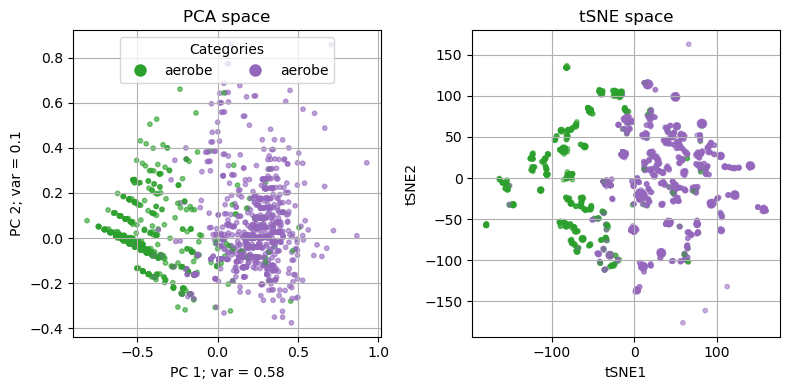

In [33]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_mi[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()


In [35]:
#ANZHELIKA's CODE

def xgboost_accur_select_features(X_train, X_test, y_train, y_test, sorted_indices, feat_step, device, feat_removal = False):
    cv_accur_arr = []
    test_accur_arr = []
 
    num_feat = range(1,len(sorted_indices),feat_step)
    num_feat_plot = []
    for N in num_feat:
        if feat_removal == False:
            select_feat = list(sorted_indices[:N])
        else:
            select_feat = list(sorted_indices[N:])
        num_feat_plot.append(N)        
       
       
        X_train_select_feat = X_train[:, select_feat] 
        X_test_select_feat = X_test[:, select_feat]
        cv_accuracy_scores, test_accuracy_scores = xgboost_train_accur(X_train_select_feat, y_train, X_test_select_feat, y_test, device)
        cv_accur_arr.append(cv_accuracy_scores)
        test_accur_arr.append(test_accuracy_scores)

    return cv_accur_arr,  test_accur_arr, num_feat_plot 

In [37]:
from sklearn.preprocessing import MaxAbsScaler

y_label_train = y_train
y_label_test = y_test

X_val_train, X_val_test = X_train.cpu(), X_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [38]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_mi, feat_step, DEVICE, feat_removal)       

In [56]:
with open('../results/aerob_O/3.1_cv_accur_arr_rem.txt', 'w') as f:
    for l in cv_accur_arr_rem:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.1_test_accur_arr_rem.txt', 'w') as f:
    for l in test_accur_arr_rem:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.1_num_feat_rem.txt', 'w') as f:
    for l in num_feat_rem:
        f.write(f'{l}\n')

In [39]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9242536307253746), 'precision': np.float64(0.9316218853596407), 'recall': np.float64(0.9598705661495899), 'f1': np.float64(0.9454819044929719), 'roc_auc': np.float64(0.9067027161051076)}
{'accuracy': 0.9461663947797716, 'precision': np.float64(0.94579945799458), 'recall': np.float64(0.9640883977900553), 'f1': np.float64(0.9548563611491108), 'roc_auc': np.float64(0.9429354405582092)}


In [40]:
def plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat):
    plt.axhline(y=test_accuracy_scores[metric], color='darkred', linestyle='--', linewidth=1.5, label='baseline test')
    plt.axhline(y=cv_accuracy_scores[metric], color='darkblue', linestyle='--', linewidth=1.5, label='baseline CV')

    plt.plot(num_feat, [scores[metric] for scores in test_accur_arr], c = "tab:red", label = "test | add")
    plt.plot(num_feat, [scores[metric] for scores in cv_accur_arr], c = "tab:blue", label = "cv | add")

    plt.plot(num_feat,  [scores[metric] for scores in test_accur_arr_rem], c = "tab:red", label = "test | remove", alpha = 0.5)
    plt.plot(num_feat, [scores[metric] for scores in cv_accur_arr_rem], c = "tab:blue", label = "cv | remove", alpha = 0.5)

    plt.xlabel("number of features added/removed")
    plt.ylabel(metric)

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (Mutual Information)')

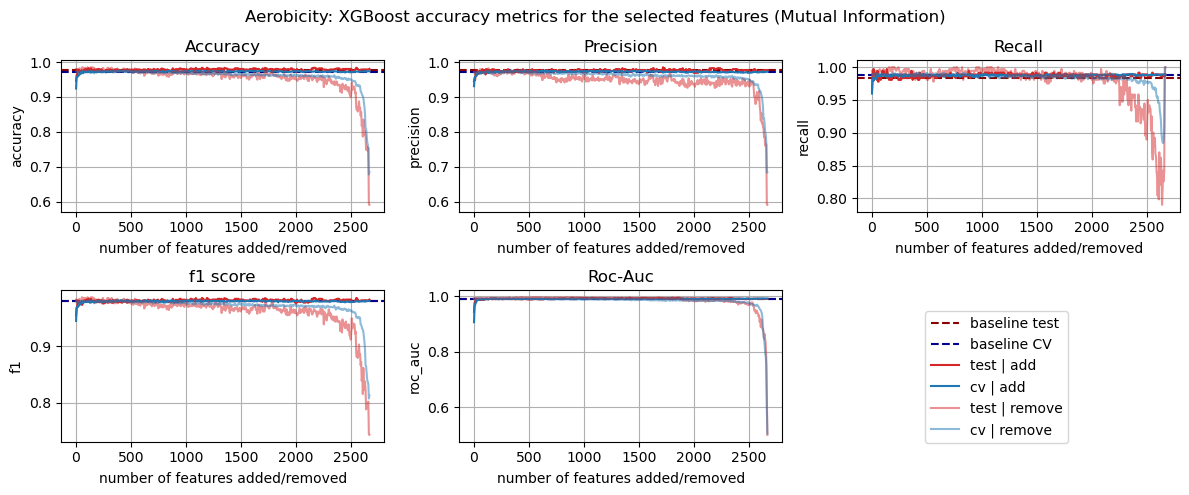

In [42]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Mutual Information)")

### 3.2 Feature selection with Random Forest

In [57]:
from feature_selection.feature_selection_utils import random_forest_features

ModuleNotFoundError: No module named 'feature_selection'

In [59]:
#ANZHELIKA's CODE

def random_forest_features(X_train, y_train, X_train_column_names, contin_flag = False):

    if contin_flag == False:
        # Train a Random Forest model
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
    else:    
        rf = RandomForestRegressor(n_estimators=100, random_state=42)

    rf.fit(X_train, y_train)

    # Get feature importances
    importances = rf.feature_importances_
    # print("Feature importances:", importances)
    # print(len(importances))

    # Select features based on importance threshold
    selector = SelectFromModel(rf, threshold='mean', prefit=True)
    X_selected = selector.transform(X_train)

    print(f"Original feature count: {X_train.shape[1]}, Selected feature count: {X_selected.shape[1]}")
    

    # plt.figure(figsize=(10, 2))
    # plt.bar(range(X_train.shape[1]), importances)
    # plt.xlabel("Feature Index")
    # plt.ylabel("Importance")
    # plt.ylim([0, max(importances)])
    # plt.show()

    sorted_indices = np.argsort(importances)[::-1]  # Reverse the order to get descending sort

    # Step 2: Use the sorted indices to get the sorted importances and corresponding names
    sorted_importances = [importances[i] for i in sorted_indices]
    sorted_names = [X_train_column_names[i] for i in sorted_indices]

    return sorted_indices, sorted_importances, sorted_names

def shap_features(X_train, y_train, X_column_names, device):
    # 1. Train the pipeline
    pipe = make_pipeline(
        XGBClassifier(
            n_jobs=THREADS if device == "cpu" else None,
            tree_method="gpu_hist" if device != "cpu" else "hist"
        )
    )
    pipe.fit(X_train.cpu(), y_train.cpu())

    # 2. Extract trained model
    model = pipe.named_steps['xgbclassifier']

    # 3. Convert X to numpy
    X_np = X_train.cpu().numpy()

    # 4. SHAP explainer
    explainer = shap.Explainer(model, X_np)  # can also use shap.TreeExplainer(model)
    shap_values = explainer(X_np)

    # 5. Extract SHAP values and compute mean absolute SHAP value per feature
    shap_vals = shap_values.values  # shape: [n_samples, n_features]
    abs_shap_vals = np.abs(shap_vals)
    mean_abs_shap_vals = np.mean(abs_shap_vals, axis=0)

    # 6. Sort features by importance
    sorted_indices = np.argsort(mean_abs_shap_vals)[::-1]
    sorted_importances = mean_abs_shap_vals[sorted_indices]
    sorted_names = [X_column_names[i] for i in sorted_indices]

    # 7. Summary plot
    plt.figure(figsize=(5, 5))
    shap.summary_plot(shap_vals, X_np, feature_names=X_column_names)
    return sorted_indices, sorted_importances, sorted_names

In [60]:

sorted_cog_idx_by_rand_forest, sorted_importances, sorted_names = random_forest_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names)

Original feature count: 2672, Selected feature count: 295


In [61]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_rand_forest[:N]
top_N_importances = sorted_importances[:N]
top_N_names_by_rand_forest = sorted_names[:N]
top_feat_rand_forest_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]]
print(f"Top {N} COGs:", top_N_names_by_rand_forest)

Top 10 COGs: ['COG0109', 'COG0843', 'COG1592', 'COG1014', 'COG0225', 'COG0508', 'COG0365', 'COG0259', 'COG0065', 'COG1612']


In [62]:
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_rand_forest[:N]])

Data after PCA reduction: (2548, 5)
Explained variance ratio: [0.52880146 0.11062183 0.08551293 0.0576331  0.05495319]
Total explained variance: 0.8375225038299601
Shape of the projected data = (2548, 2)


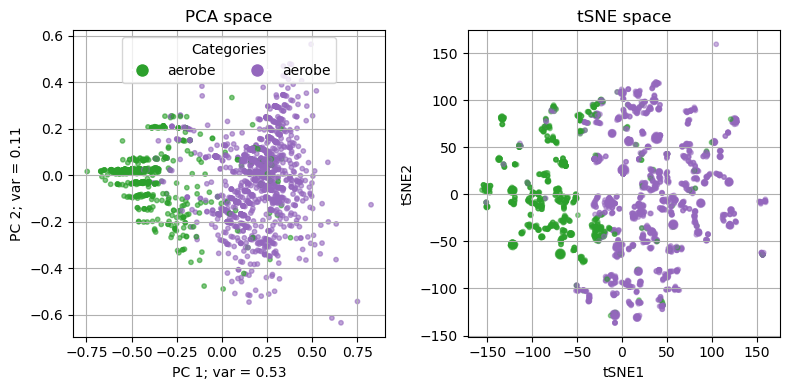

In [63]:
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']
pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [64]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [65]:
with open('../results/aerob_O/3.2_cv_accur_arr.txt', 'w') as f:
    for l in cv_accur_arr:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.2_test_accur_arr.txt', 'w') as f:
    for l in test_accur_arr:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.2_num_feat.txt', 'w') as f:
    for l in num_feat:
        f.write(f'{l}\n')

In [66]:
print(cv_accur_arr[0])
print(test_accur_arr[0])

{'accuracy': np.float64(0.9242536307253746), 'precision': np.float64(0.9316218853596407), 'recall': np.float64(0.9598705661495899), 'f1': np.float64(0.9454819044929719), 'roc_auc': np.float64(0.9067027161051076)}
{'accuracy': 0.9461663947797716, 'precision': np.float64(0.94579945799458), 'recall': np.float64(0.9640883977900553), 'f1': np.float64(0.9548563611491108), 'roc_auc': np.float64(0.9429354405582092)}


In [67]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_rand_forest, feat_step, DEVICE, feat_removal)       

In [70]:
with open('../results/aerob_O/3.2_cv_accur_arr_rem.txt', 'w') as f:
    for l in cv_accur_arr_rem:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.2_test_accur_arr_rem.txt', 'w') as f:
    for l in test_accur_arr_rem:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.2_num_feat.txt', 'w') as f:
    for l in num_feat:
        f.write(f'{l}\n')

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)')

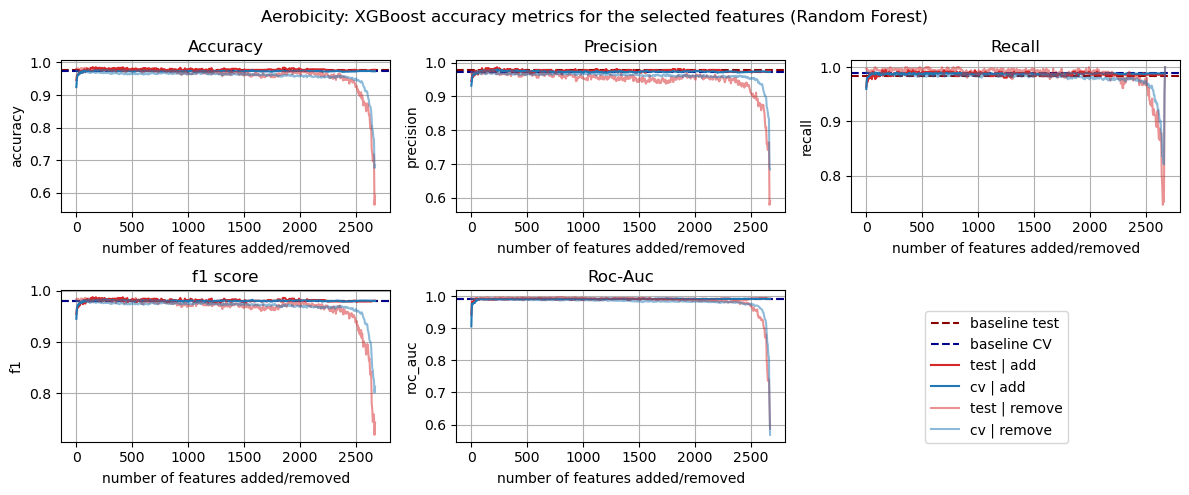

In [69]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (Random Forest)")

### 3.3 SHAP values

In [71]:
from feature_selection.feature_selection_utils import shap_features


ModuleNotFoundError: No module named 'feature_selection'

In [72]:
#ANZHELIKA's CODE

def shap_features(X_train, y_train, X_column_names, device):
    # 1. Train the pipeline
    pipe = make_pipeline(
        XGBClassifier(
            n_jobs=THREADS if device == "cpu" else None,
            tree_method="gpu_hist" if device != "cpu" else "hist"
        )
    )
    pipe.fit(X_train.cpu(), y_train.cpu())

    # 2. Extract trained model
    model = pipe.named_steps['xgbclassifier']

    # 3. Convert X to numpy
    X_np = X_train.cpu().numpy()

    # 4. SHAP explainer
    explainer = shap.Explainer(model, X_np)  # can also use shap.TreeExplainer(model)
    shap_values = explainer(X_np)

    # 5. Extract SHAP values and compute mean absolute SHAP value per feature
    shap_vals = shap_values.values  # shape: [n_samples, n_features]
    abs_shap_vals = np.abs(shap_vals)
    mean_abs_shap_vals = np.mean(abs_shap_vals, axis=0)

    # 6. Sort features by importance
    sorted_indices = np.argsort(mean_abs_shap_vals)[::-1]
    sorted_importances = mean_abs_shap_vals[sorted_indices]
    sorted_names = [X_column_names[i] for i in sorted_indices]

    # 7. Summary plot
    plt.figure(figsize=(5, 5))
    shap.summary_plot(shap_vals, X_np, feature_names=X_column_names)
    return sorted_indices, sorted_importances, sorted_names

In [75]:
THREADS = 64

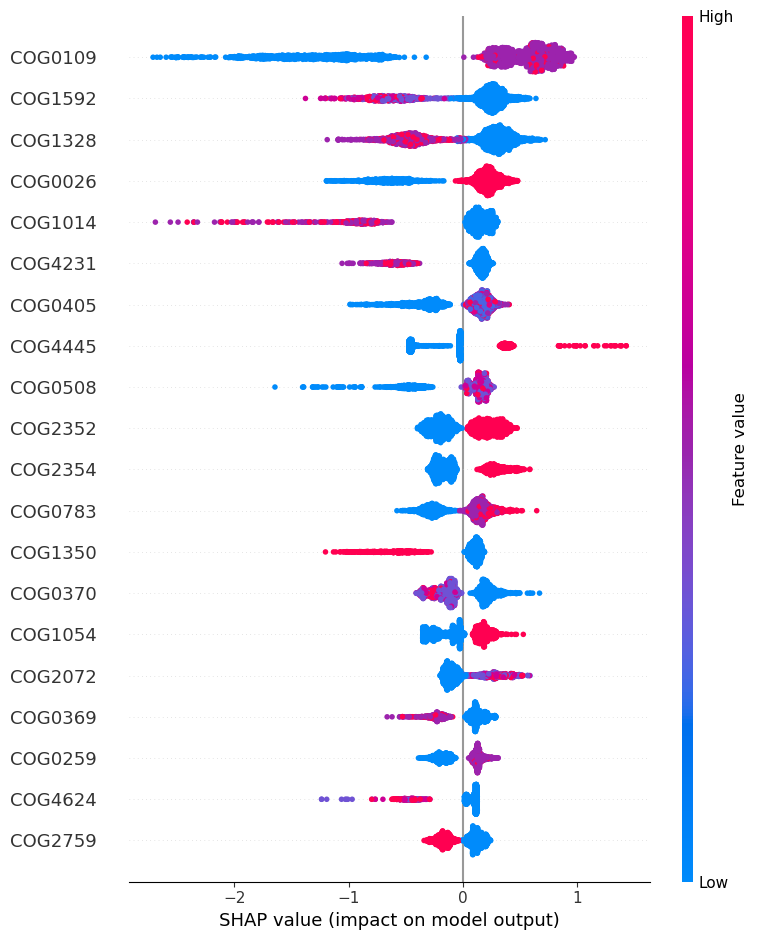

In [76]:
device = 'cpu'
sorted_cog_idx_by_shap, sorted_shap, sorted_names = shap_features(X_val_train.cpu(), y_label_train.cpu(), X_column_names, device) 

In [77]:
# Select the top N features
N = 10
top_N_indices = sorted_cog_idx_by_shap[:N]
top_N_mi = sorted_shap[:N]
top_N_names_by_shap = sorted_names[:N]
top_feat_shap_counts = [X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]]

print(f"Top {N} COGs:", top_N_names_by_shap)

Top 10 COGs: ['COG0109', 'COG1592', 'COG1328', 'COG0026', 'COG1014', 'COG4231', 'COG0405', 'COG4445', 'COG0508', 'COG2352']


Data after PCA reduction: (2548, 5)
Explained variance ratio: [0.47464646 0.15769338 0.0928136  0.06639137 0.05821988]
Total explained variance: 0.8497646879406664
Shape of the projected data = (2548, 2)


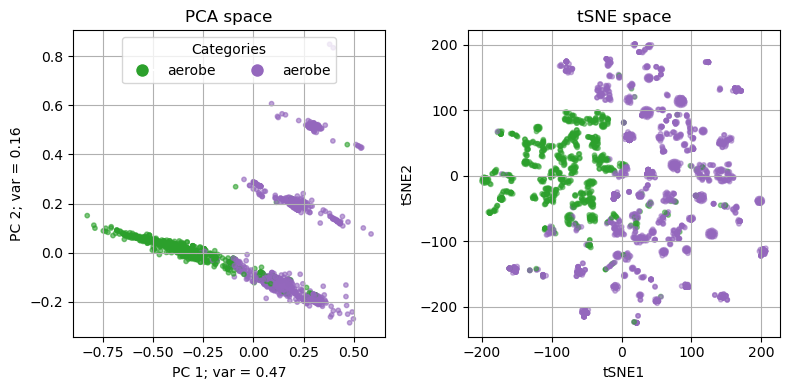

In [78]:
plt.figure(figsize=(8, 4))
X_top_feat = np.array([X_train_transposed[i] for i in sorted_cog_idx_by_shap[:N]])

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 5 
colors = ListedColormap(["tab:green", "tab:purple"])
category_names = full_data['oxytolerance']

pca_run_and_plot(X_top_feat.T, n_compon, y_label_train.cpu(), category_names, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_top_feat.T, 10, 50, 42, y_label_train.cpu(),colors);

# Display the plots
plt.tight_layout()  
plt.show()

In [79]:
from sklearn.preprocessing import MaxAbsScaler

X_val_train, X_val_test = X_val_train.cpu(), X_val_test.cpu()
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.fit_transform(X_val_test)

feat_step = 5
feat_removal = False
cv_accur_arr, test_accur_arr, num_feat = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

In [80]:
feat_removal = True
cv_accur_arr_rem, test_accur_arr_rem, num_feat_rem = xgboost_accur_select_features(X_val_train.cpu(), X_val_test.cpu(), y_label_train.cpu(), y_label_test.cpu(), sorted_cog_idx_by_shap, feat_step, DEVICE, feat_removal)       

In [82]:
with open('../results/aerob_O/3.3_cv_accur_arr_rem.txt', 'w') as f:
    for l in cv_accur_arr_rem:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.3_test_accur_arr_rem.txt', 'w') as f:
    for l in test_accur_arr_rem:
        f.write(f'{l}\n')

with open('../results/aerob_O/3.3_num_feat.txt', 'w') as f:
    for l in num_feat:
        f.write(f'{l}\n')

Text(0.5, 0.98, 'Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)')

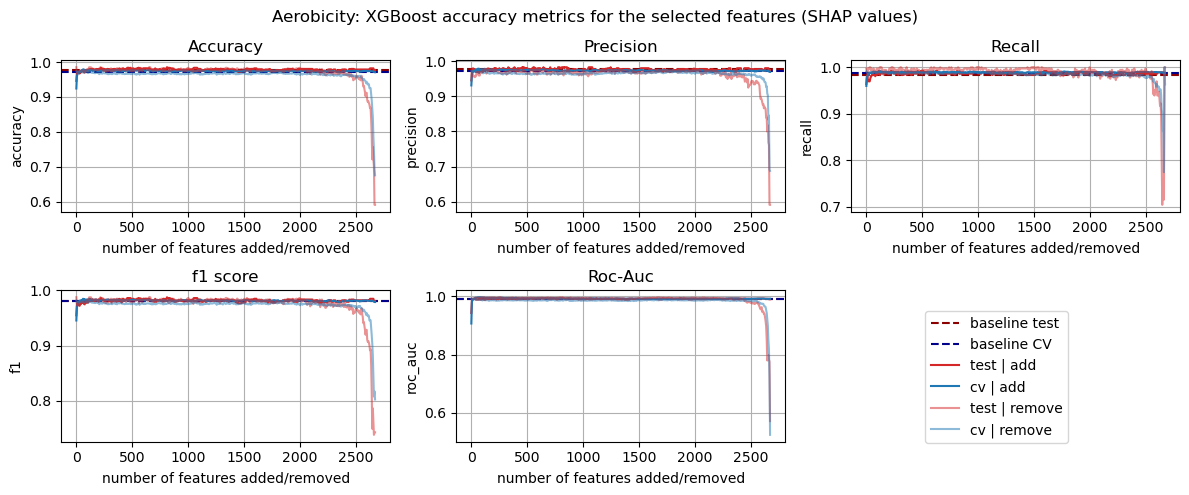

In [81]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(2, 3, 1)
metric = 'accuracy'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Accuracy")
plt.grid()

plt.subplot(2, 3, 2)
metric = 'precision'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Precision")
plt.grid()

plt.subplot(2, 3, 3)
metric = 'recall'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Recall")
plt.grid()

plt.subplot(2, 3, 4)
metric = 'f1'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("f1 score")
plt.grid()

plt.subplot(2, 3, 5)
metric = 'roc_auc'
plot_accuracy_metric(metric, test_accuracy_scores, cv_accuracy_scores, test_accur_arr, test_accur_arr_rem, cv_accur_arr, cv_accur_arr_rem, num_feat)
plt.title("Roc-Auc")
plt.grid()

plt.tight_layout(h_pad=1.5, w_pad=2.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave top 5% of figure for suptitle
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.9, 0.1))  # near bottom-right of full figure

plt.suptitle("Aerobicity: XGBoost accuracy metrics for the selected features (SHAP values)")

In [98]:
!pwd

/Users/olgabagrova/olgab/gene-context/jupyter_notebooks


In [105]:
!ls /Users/olgabagrova/olgab/gene-context/utils

__init__.py __pycache__ utils.py


In [104]:
from utils.utils import str2bool

ImportError: cannot import name 'str2bool' from 'utils.utils' (/Users/olgabagrova/olgab/gene-context/jupyter_notebooks/utils/utils.py)

In [103]:
from utils.utils_ import generate_tables